# Package Releases Lookahead Metrics

### Setup

In [1]:
import re
from pathlib import Path
from itertools import combinations

import seaborn as sns
import opinionated  # noqa
import colormaps as cmaps
import matplotlib.pyplot as plt
import polars as pl
from scipy.stats import f_oneway, ttest_ind

plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# Data dir
data_dir = (
    Path("../data/per-day-pkg-releases-metrics-six-months/")
    .expanduser()
    .resolve()
    .absolute()
)

# Lazy read parquet files (all files in dir via glob)
lazy_frame = pl.scan_parquet(source=data_dir / "*")

# Lowercase all column names
lazy_frame = lazy_frame.select(pl.all().reverse().name.to_lowercase())

# Rename "normalized_package_manager" to "ecosystem"
lazy_frame = lazy_frame.with_columns(
    pl.col("normalized_package_manager").alias("ecosystem")
)

# Tame a random sample
lazy_frame.head(5).collect()

repo_created_date,package_managers,package_version,package_major_version,package_minor_version,package_patch_version,release_type,publish_datetime,publish_date,num_dependencies,num_stars_day_of_release,num_public_forks_day_of_release,num_dependents_on_release_date,num_dependents_plus_45_days,num_stars_plus_45_days,num_forks_plus_45_days,num_dependents_plus_90_days,num_stars_plus_90_days,num_forks_plus_90_days,num_dependents_plus_135_days,num_stars_plus_135_days,num_forks_plus_135_days,num_dependents_plus_180_days,num_stars_plus_180_days,num_forks_plus_180_days,normalized_package_manager,package_uuid,ecosystem
str,str,str,f64,f64,f64,str,datetime[ns],str,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str
"""2024-01-27""","""npm""","""0.0.1""",0.0,1.0,null,"""zero-minor""",2024-02-01 09:19:16,"""2024-02-01""",8,7.0,0,0.0,0.0,13.0,0.0,0.0,13.0,0.0,0.0,13.0,0.0,0.0,13.0,0.0,"""npm""","""d104f7dc-6908-4a45-bfe3-1404d4…","""npm"""
"""2022-06-24""","""pypi""","""1.1.1""",1.0,1.0,1.0,"""patch""",2024-02-01 22:25:36,"""2024-02-01""",2,3.0,2,0.0,0.0,4.0,2.0,0.0,4.0,2.0,0.0,4.0,2.0,0.0,5.0,2.0,"""pypi""","""3e65db78-e1f2-4600-839d-72b2af…","""pypi"""
"""2023-05-01""","""pypi""","""1.2""",1.0,2.0,null,"""minor""",2024-02-01 15:24:14,"""2024-02-01""",4,2.0,0,0.0,0.0,3.0,1.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,4.0,1.0,"""pypi""","""df43af42-078f-40b8-9e5e-59de4b…","""pypi"""
"""2024-02-01""","""rubygems""","""0.1.0""",1.0,0.0,null,"""zero-major""",2024-02-01 08:00:00,"""2024-02-01""",2,2.0,0,0.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,4.0,1.0,"""rubygems""","""698b8802-baa0-40f4-8436-111e4b…","""rubygems"""
"""2022-05-09""","""pub""","""0.2.0""",2.0,0.0,null,"""zero-major""",2024-02-01 09:28:47,"""2024-02-01""",1,26.0,1,0.0,0.0,27.0,1.0,0.0,28.0,3.0,0.0,27.0,3.0,0.0,29.0,3.0,"""pub""","""9f6a9172-041f-4464-9e28-fdc6c2…","""pub"""


In [3]:
# Compute number of unique packages
num_unique_packages = len(lazy_frame.select("package_uuid").unique().collect())
print(f"Number of unique packages: {num_unique_packages}")

Number of unique packages: 162103


## Demographics

### Package Releases by Ecosystem

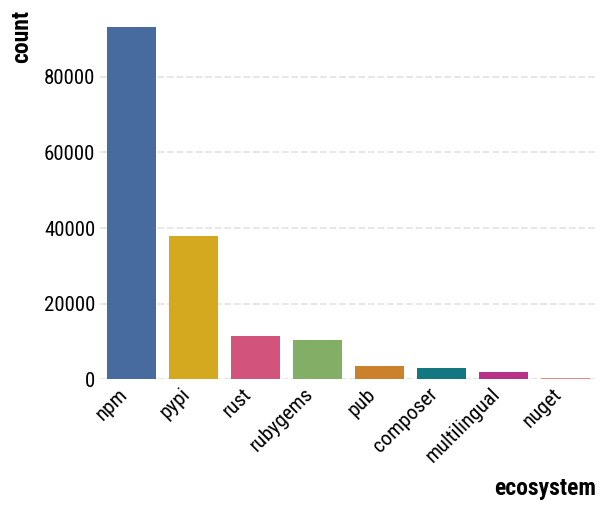

In [4]:
# Count plot of package manager
ecosystem_counts = (
    lazy_frame.unique(subset="package_uuid", keep="first")
    .select(pl.col("ecosystem").value_counts(sort=True))
    .collect()
    .unnest("ecosystem")
).top_k(8, by="count")

_ = sns.barplot(
    data=ecosystem_counts,
    x="ecosystem",
    y="count",
    hue="ecosystem",
)
_ = plt.xticks(rotation=45, ha="right")

In [5]:
ecosystem_counts

ecosystem,count
str,u32
"""npm""",92995
"""pypi""",37971
"""rust""",11485
"""rubygems""",10540
"""pub""",3652
"""composer""",2915
"""multilingual""",1884
"""nuget""",498


### Package Releases by Release Type

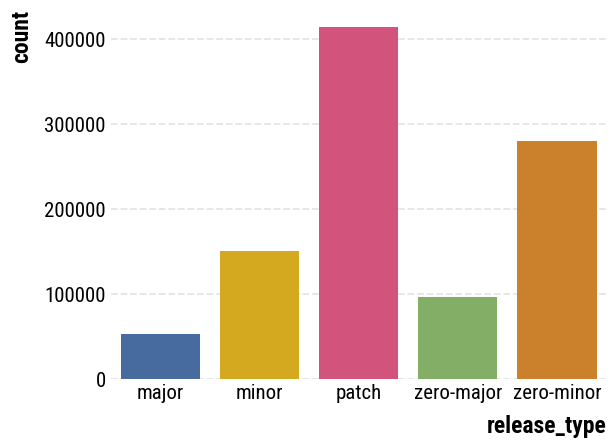

In [6]:
release_type_counts = (
    lazy_frame.filter(pl.col("release_type") != "unknown")
    .select(pl.col("release_type").value_counts())
    .unnest("release_type")
    .sort(by="release_type")
    .collect()
)

# Plot count of release types
_ = sns.barplot(
    data=release_type_counts,
    x="release_type",
    y="count",
    hue="release_type",
)

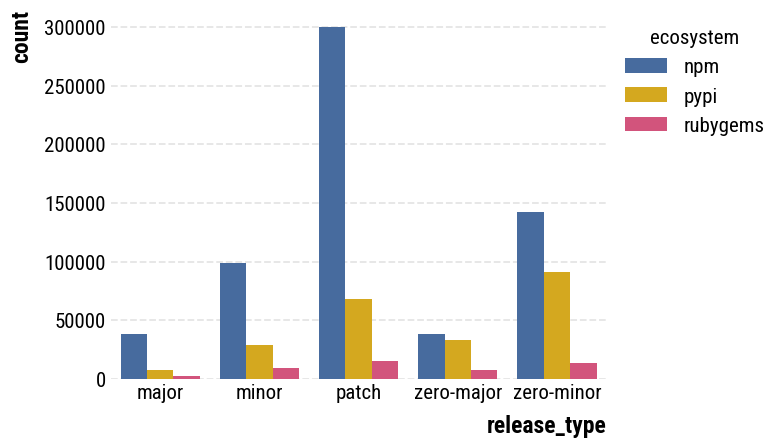

In [7]:
ecosystem_releases_counts = (
    lazy_frame.select(pl.col(["ecosystem", "release_type"]))
    .filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .filter(pl.col("release_type") != "unknown")
    .group_by(pl.all())
    .len(name="count")
    .sort(by=["ecosystem", "release_type"])
    .collect()
)

ax = sns.barplot(
    data=ecosystem_releases_counts,
    x="release_type",
    y="count",
    hue="ecosystem",
    hue_order=["npm", "pypi", "rubygems"],
)

# Move legend outside of plot
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Distribution of Release Day Dependent Counts by Ecosystem

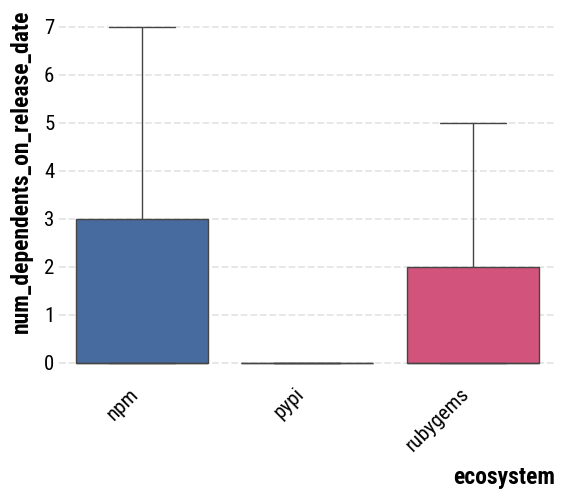

In [8]:
sns.boxplot(
    data=lazy_frame.select(
        pl.col("ecosystem"),
        pl.col("num_dependents_on_release_date"),
    )
    .filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .collect(),
    x="ecosystem",
    y="num_dependents_on_release_date",
    hue="ecosystem",
    hue_order=["npm", "pypi", "rubygems"],
    showfliers=False,
)

_ = plt.xticks(rotation=45, ha="right")

In [9]:
lazy_frame.select(
    pl.col("ecosystem"),
    pl.col("num_dependents_on_release_date"),
).group_by(pl.col("ecosystem"),).quantile(0.5).filter(
    pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_dependents_on_release_date", descending=True
)

ecosystem,num_dependents_on_release_date
str,f64
"""rubygems""",0.0
"""npm""",0.0
"""pypi""",0.0


In [10]:
lazy_frame.select(
    pl.col("ecosystem"),
    pl.col("num_dependents_on_release_date"),
).group_by(pl.col("ecosystem"),).quantile(0.75).filter(
    pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_dependents_on_release_date", descending=True
)

ecosystem,num_dependents_on_release_date
str,f64
"""npm""",3.0
"""rubygems""",2.0
"""pypi""",0.0


### Distribution of Release Day Star Counts by Release Type

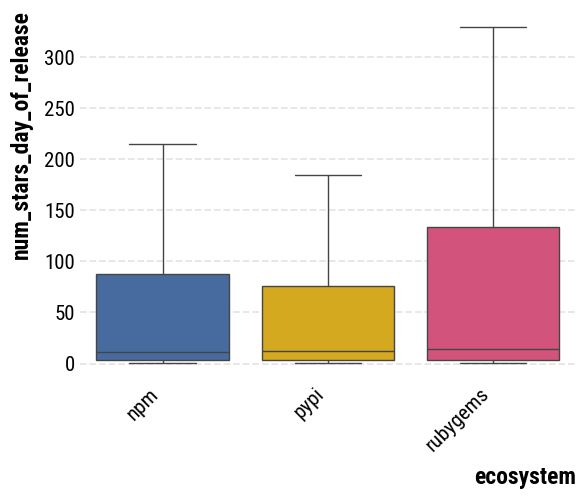

In [11]:
sns.boxplot(
    data=lazy_frame.select(
        pl.col("ecosystem"),
        pl.col("num_stars_day_of_release"),
    )
    .filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .collect(),
    x="ecosystem",
    y="num_stars_day_of_release",
    hue="ecosystem",
    hue_order=["npm", "pypi", "rubygems"],
    showfliers=False,
)

_ = plt.xticks(rotation=45, ha="right")

In [12]:
lazy_frame.select(
    pl.col("ecosystem"),
    pl.col("num_stars_day_of_release"),
).group_by(
    pl.col("ecosystem"),
).quantile(0.10).filter(
    pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_stars_day_of_release", descending=True
)

ecosystem,num_stars_day_of_release
str,f64
"""rubygems""",1.0
"""npm""",1.0
"""pypi""",1.0


In [13]:
lazy_frame.select(
    pl.col("ecosystem"),
    pl.col("num_stars_day_of_release"),
).group_by(
    pl.col("ecosystem"),
).quantile(0.25).filter(
    pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"])
).collect().sort(
    by="num_stars_day_of_release", descending=True
)

ecosystem,num_stars_day_of_release
str,f64
"""rubygems""",3.0
"""pypi""",3.0
"""npm""",3.0


## Look Ahead Metrics

### Stars

#### Setup

In [14]:
selected_columns = [
    col_name
    for col_name in lazy_frame.collect_schema().names()
    if "num_stars_" in col_name
]

# Calculate log difference in stars
constructed_exprs = []
for col_name in selected_columns:
    # Ignore the 0 day
    if col_name == "num_stars_day_of_release":
        continue

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                pl.when(pl.col("num_stars_day_of_release").gt(pl.lit(0)))
                .then(
                    (pl.col(col_name).log() - pl.col("num_stars_day_of_release").log())
                )
                .otherwise(
                    pl.lit(0),
                )
            ).alias(f"log_difference_stars_{timedelta_int}_days")
        )

# Create new column for log difference stars
log_diff_stars_ecosystem_release_type = (
    lazy_frame.filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .filter(pl.col("release_type") != "unknown")
    .filter(pl.col("num_stars_day_of_release").gt(pl.lit(1)))
    .select(
        pl.col("package_uuid"),
        pl.col("package_version"),
        pl.col("package_major_version"),
        pl.col("ecosystem"),
        pl.col("release_type"),
        # Quantile bins for num_stars
        pl.col("num_stars_day_of_release")
        .qcut(
            [0.25, 0.75],
            labels=["bottom-25", "middle-50", "top-25"],
        )
        .over("ecosystem")
        .alias("num_stars_quantile"),
        # Version series bins
        pl.when(
            pl.col("release_type").is_in(["zero-major", "zero-minor"]),
        )
        .then(pl.lit("zero-ver"))
        .when(
            pl.col("package_major_version").eq(pl.lit(1)),
        )
        .then(pl.lit("one-ver"))
        .otherwise(pl.lit("two-plus-ver"))
        .alias("version_series"),
        *constructed_exprs,
    )
    .unpivot(
        index=[
            "package_uuid",
            "ecosystem",
            "release_type",
            "package_version",
            "package_major_version",
            "num_stars_quantile",
            "version_series",
        ],
        variable_name="days_since_release",
        value_name="log_difference_stars",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(
            r"^(log_difference_stars_)(\d+)(_days)$",
            r"$2",
        )
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
    .collect()
)

#### Log Difference in Stars by Ecosystem and Initial Popularity

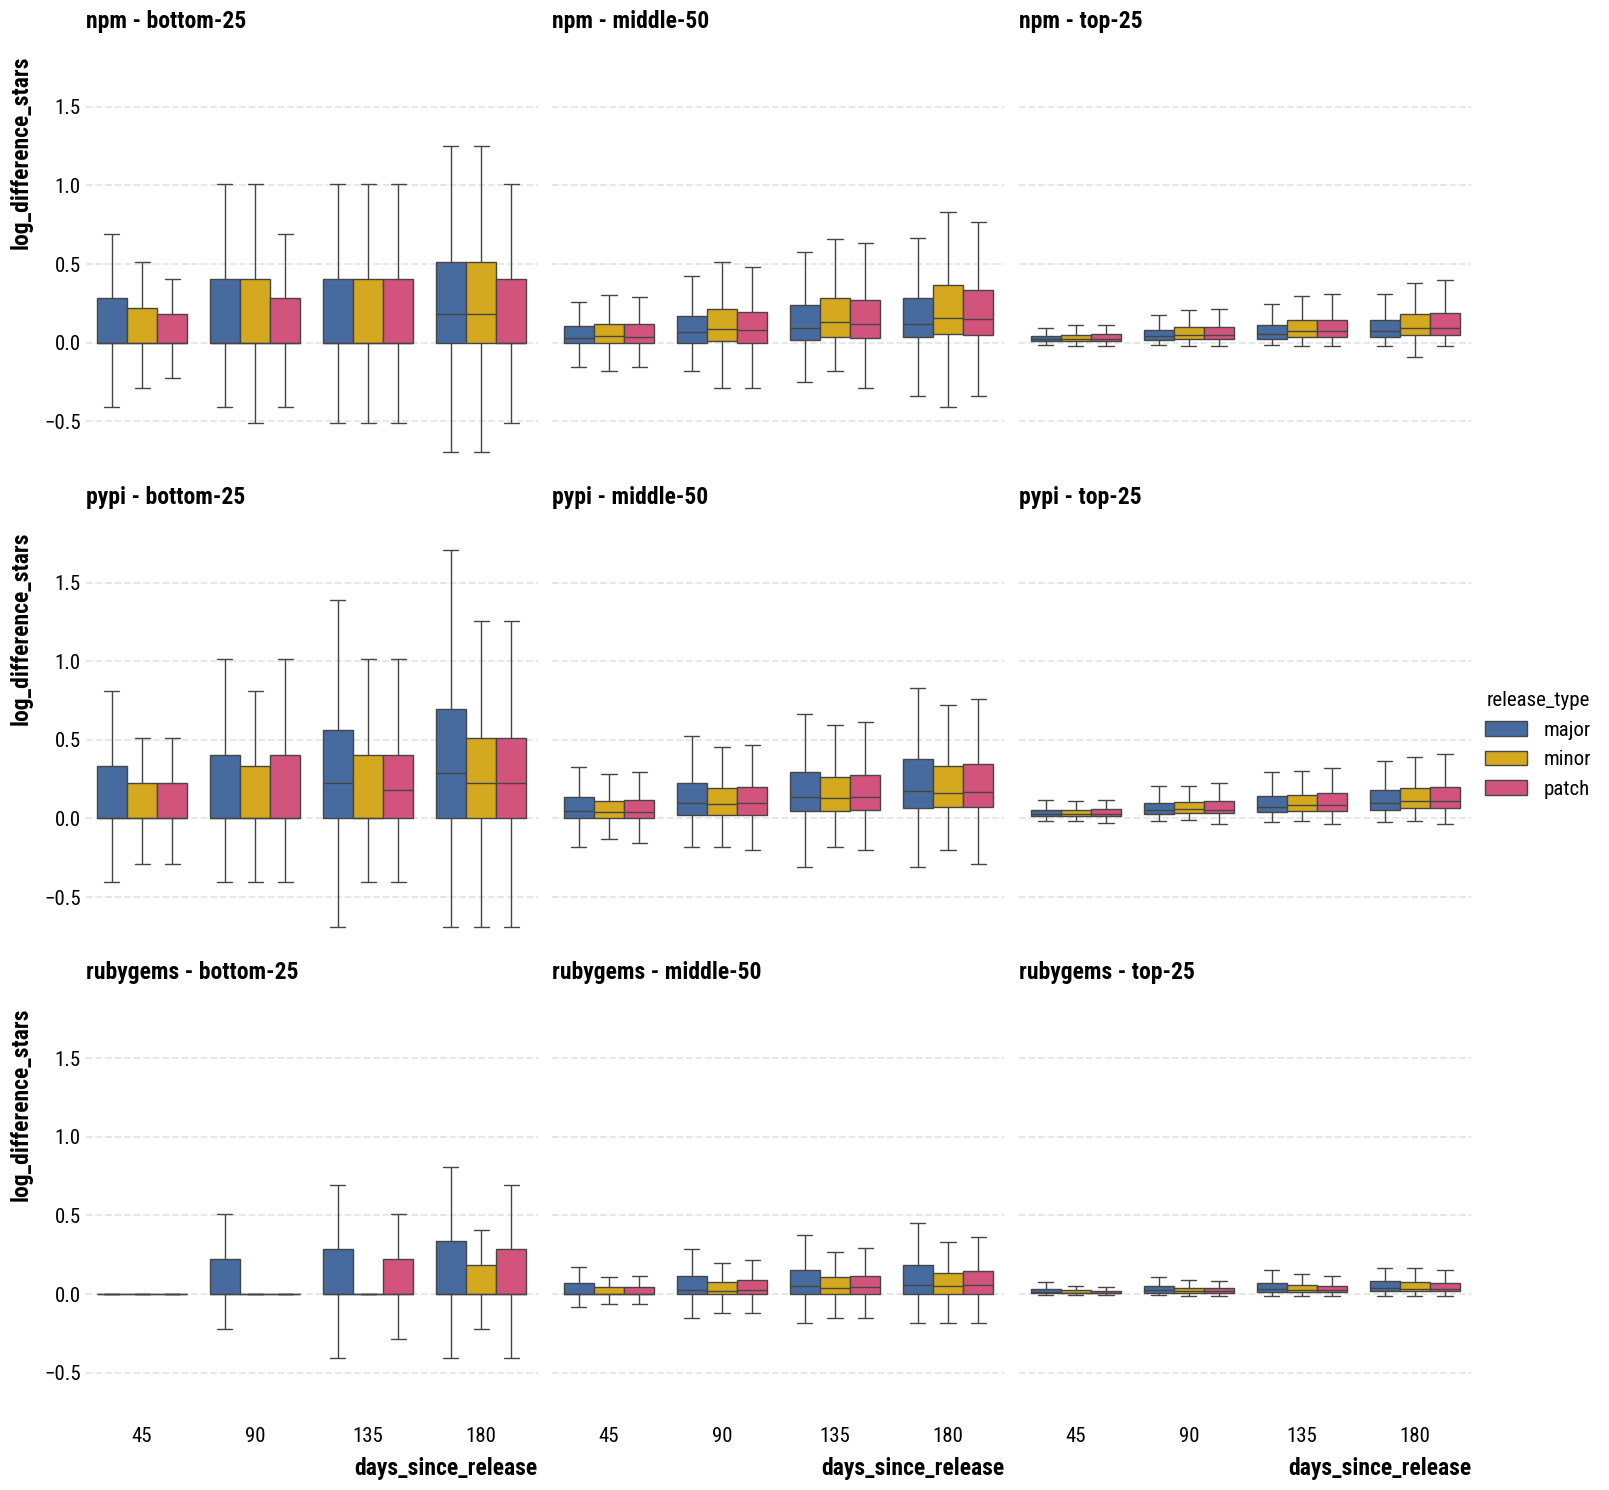

In [15]:
# Plot log difference stars
g = sns.catplot(
    data=log_diff_stars_ecosystem_release_type,
    x="days_since_release",
    y="log_difference_stars",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="num_stars_quantile",
    col_order=["bottom-25", "middle-50", "top-25"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

#### Log Difference in Stars by Ecosystem and Release Series

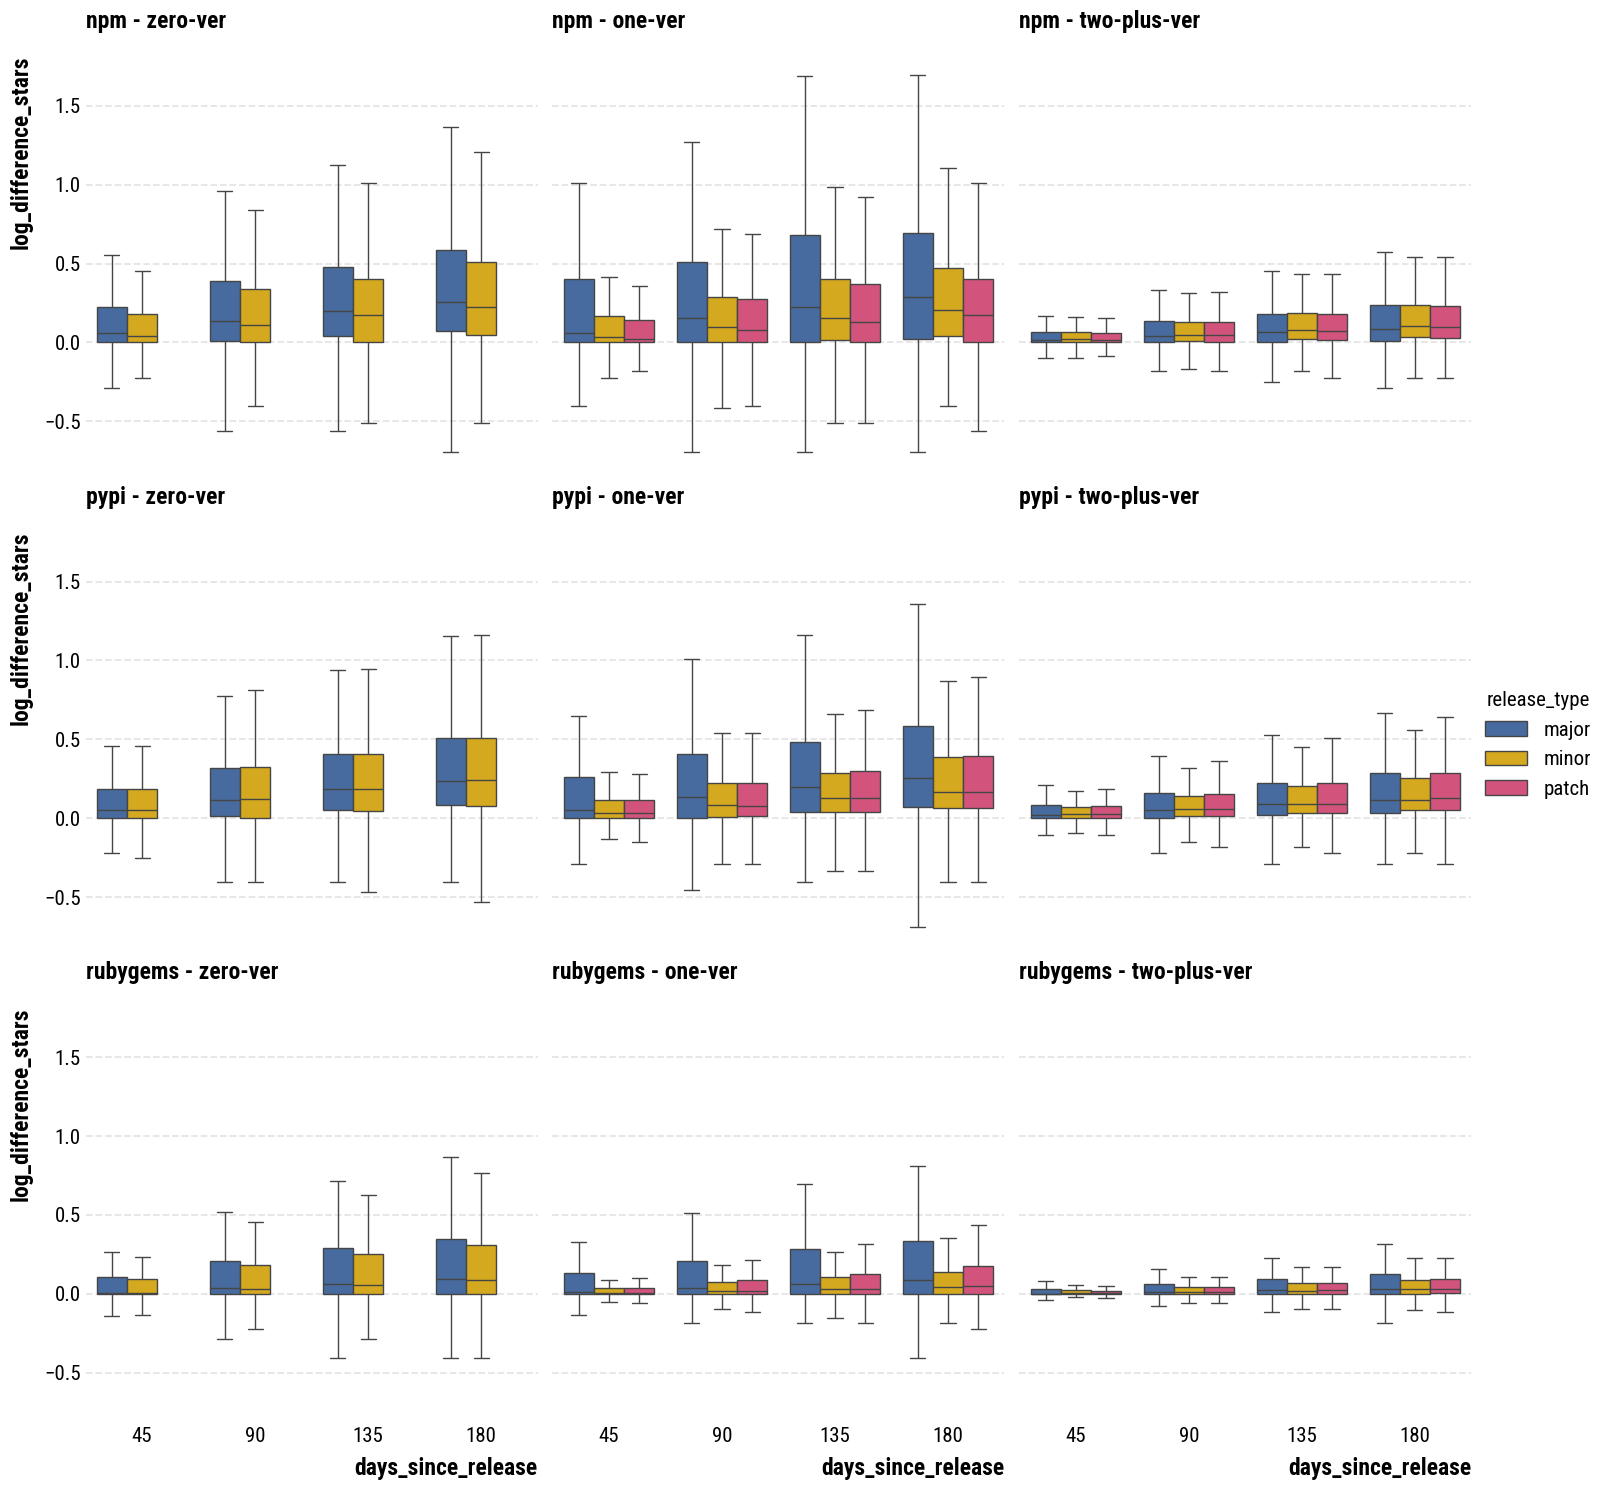

In [16]:
# Last step is to replace zero-major and zero-minor specifically for this plot
log_diff_stars_ecosystem_release_type_replaced_zero_ver = (
    log_diff_stars_ecosystem_release_type.select(
        pl.all().exclude("release_type"),
        pl.col("release_type")
        .str.replace("zero-major", "major")
        .str.replace("zero-minor", "minor")
        .alias("release_type"),
    )
)


# Plot log difference stars
g = sns.catplot(
    data=log_diff_stars_ecosystem_release_type_replaced_zero_ver,
    x="days_since_release",
    y="log_difference_stars",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="version_series",
    col_order=["zero-ver", "one-ver", "two-plus-ver"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

### Dependents

#### Setup

In [17]:
selected_columns = [
    col_name
    for col_name in lazy_frame.collect_schema().names()
    if "num_dependents_" in col_name
]

# Calculate log difference in dependents
constructed_exprs = []
for col_name in selected_columns:
    # Ignore the 0 day
    if col_name == "num_dependents_on_release_date":
        continue

    # Handle timedelta additions based on col name
    else:
        # Get the integer days within the col name
        timedelta_int = int(re.findall(r"\d+", col_name)[0])

        constructed_exprs.append(
            (
                pl.when(pl.col("num_dependents_on_release_date").gt(pl.lit(0)))
                .then(
                    (
                        pl.col(col_name).log()
                        - pl.col("num_dependents_on_release_date").log()
                    )
                )
                .otherwise(
                    pl.lit(0),
                )
            ).alias(f"log_difference_dependents_{timedelta_int}_days")
        )

# Create new column for log difference dependents
log_diff_dependents_ecosystem_release_type = (
    lazy_frame.filter(pl.col("ecosystem").is_in(["npm", "pypi", "rubygems"]))
    .filter(pl.col("release_type") != "unknown")
    .filter(pl.col("num_dependents_on_release_date").gt(pl.lit(1)))
    .select(
        pl.col("package_uuid"),
        pl.col("package_version"),
        pl.col("package_major_version"),
        pl.col("ecosystem"),
        pl.col("release_type"),
        # Quantile bins for num_dependents
        pl.col("num_dependents_on_release_date")
        .qcut(
            [0.25, 0.75],
            labels=["bottom-25", "middle-50", "top-25"],
        )
        .over("ecosystem")
        .alias("num_dependents_quantile"),
        # Version series bins
        pl.when(
            pl.col("release_type").is_in(["zero-major", "zero-minor"]),
        )
        .then(pl.lit("zero-ver"))
        .when(
            pl.col("package_major_version").eq(pl.lit(1)),
        )
        .then(pl.lit("one-ver"))
        .otherwise(pl.lit("two-plus-ver"))
        .alias("version_series"),
        *constructed_exprs,
    )
    .unpivot(
        index=[
            "package_uuid",
            "ecosystem",
            "release_type",
            "package_version",
            "package_major_version",
            "num_dependents_quantile",
            "version_series",
        ],
        variable_name="days_since_release",
        value_name="log_difference_dependents",
    )
    .select(
        pl.all().exclude("days_since_release"),
        pl.col("days_since_release")
        .str.replace(
            r"^(log_difference_dependents_)(\d+)(_days)$",
            r"$2",
        )
        .cast(pl.Int32)
        .alias("days_since_release"),
    )
    .sort(by=["release_type"])
    .collect()
)

#### ANOVA of Log Difference in Dependents by Ecosystem at One Year

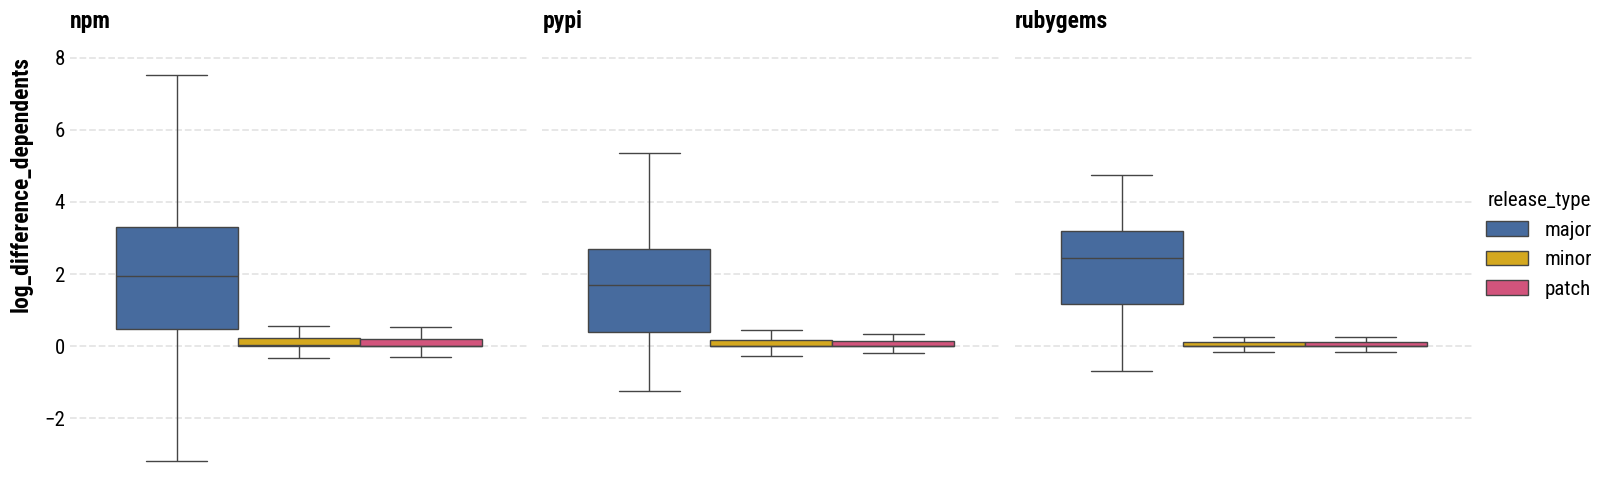

In [18]:
anova_data = (
    log_diff_dependents_ecosystem_release_type.filter(
        pl.col("log_difference_dependents").is_null().not_()
    )
    .filter(pl.col("log_difference_dependents").is_infinite().not_())
    .filter(pl.col("days_since_release").eq(pl.lit(180)))
)

# Plot log difference dependents
g = sns.catplot(
    data=anova_data,
    # x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    col="ecosystem",
    col_order=["npm", "pypi", "rubygems"],
    showfliers=False,
)

g.set_titles("{col_name}")

In [19]:
def compute_anova_and_post_hocs_for_ecosystem(
    data: pl.DataFrame,
    ecosystem: str,
) -> None:
    # One way ANOVA for ecosystem
    distributions = {
        release_type: data.filter(pl.col("ecosystem").eq(pl.lit(ecosystem)))
        .filter(pl.col("release_type").eq(pl.lit(release_type)))
        .select(pl.col("log_difference_dependents"))
        .get_column("log_difference_dependents")
        .to_numpy()
        for release_type in ["major", "minor", "patch"]
    }

    result = f_oneway(*distributions.values())
    print(result)

    if result.pvalue < 0.05:
        print("Distributions are significantly different")
        print()

        # Conduct pairwise t-tests
        for release_type1, release_type2 in combinations(distributions.keys(), 2):
            post_hoc_result = ttest_ind(
                distributions[release_type1],
                distributions[release_type2],
            )

            if post_hoc_result.pvalue < 0.05:
                print(release_type1, release_type2, post_hoc_result)
                print(
                    release_type1,
                    round(distributions[release_type1].mean(), 3),
                    round(distributions[release_type1].std(), 3),
                )
                print(
                    release_type2,
                    round(distributions[release_type2].mean(), 3),
                    round(distributions[release_type2].std(), 3),
                )


# Compute ANOVA and post hocs for each ecosystem
for ecosystem in ["npm", "pypi", "rubygems"]:
    print(f"ECOSYSTEM: {ecosystem}")
    print()
    compute_anova_and_post_hocs_for_ecosystem(
        data=anova_data,
        ecosystem=ecosystem,
    )
    print()
    print("-" * 80)

ECOSYSTEM: npm

F_onewayResult(statistic=np.float64(17633.950430719164), pvalue=np.float64(0.0))
Distributions are significantly different

major minor TtestResult(statistic=np.float64(152.7016116001909), pvalue=np.float64(0.0), df=np.float64(50909.0))
major 2.081 1.901
minor 0.107 0.584
major patch TtestResult(statistic=np.float64(181.5434292500871), pvalue=np.float64(0.0), df=np.float64(126814.0))
major 2.081 1.901
patch 0.114 0.576
minor patch TtestResult(statistic=np.float64(-2.4942372363940395), pvalue=np.float64(0.012623755675493934), df=np.float64(170191.0))
minor 0.107 0.584
patch 0.114 0.576

--------------------------------------------------------------------------------
ECOSYSTEM: pypi

F_onewayResult(statistic=np.float64(2034.306515749035), pvalue=np.float64(0.0))
Distributions are significantly different

major minor TtestResult(statistic=np.float64(55.010818257476046), pvalue=np.float64(0.0), df=np.float64(9332.0))
major 1.656 1.369
minor 0.078 0.416
major patch TtestResu

#### Log Difference in Dependents by Package Ecosystem and Initial Utilization

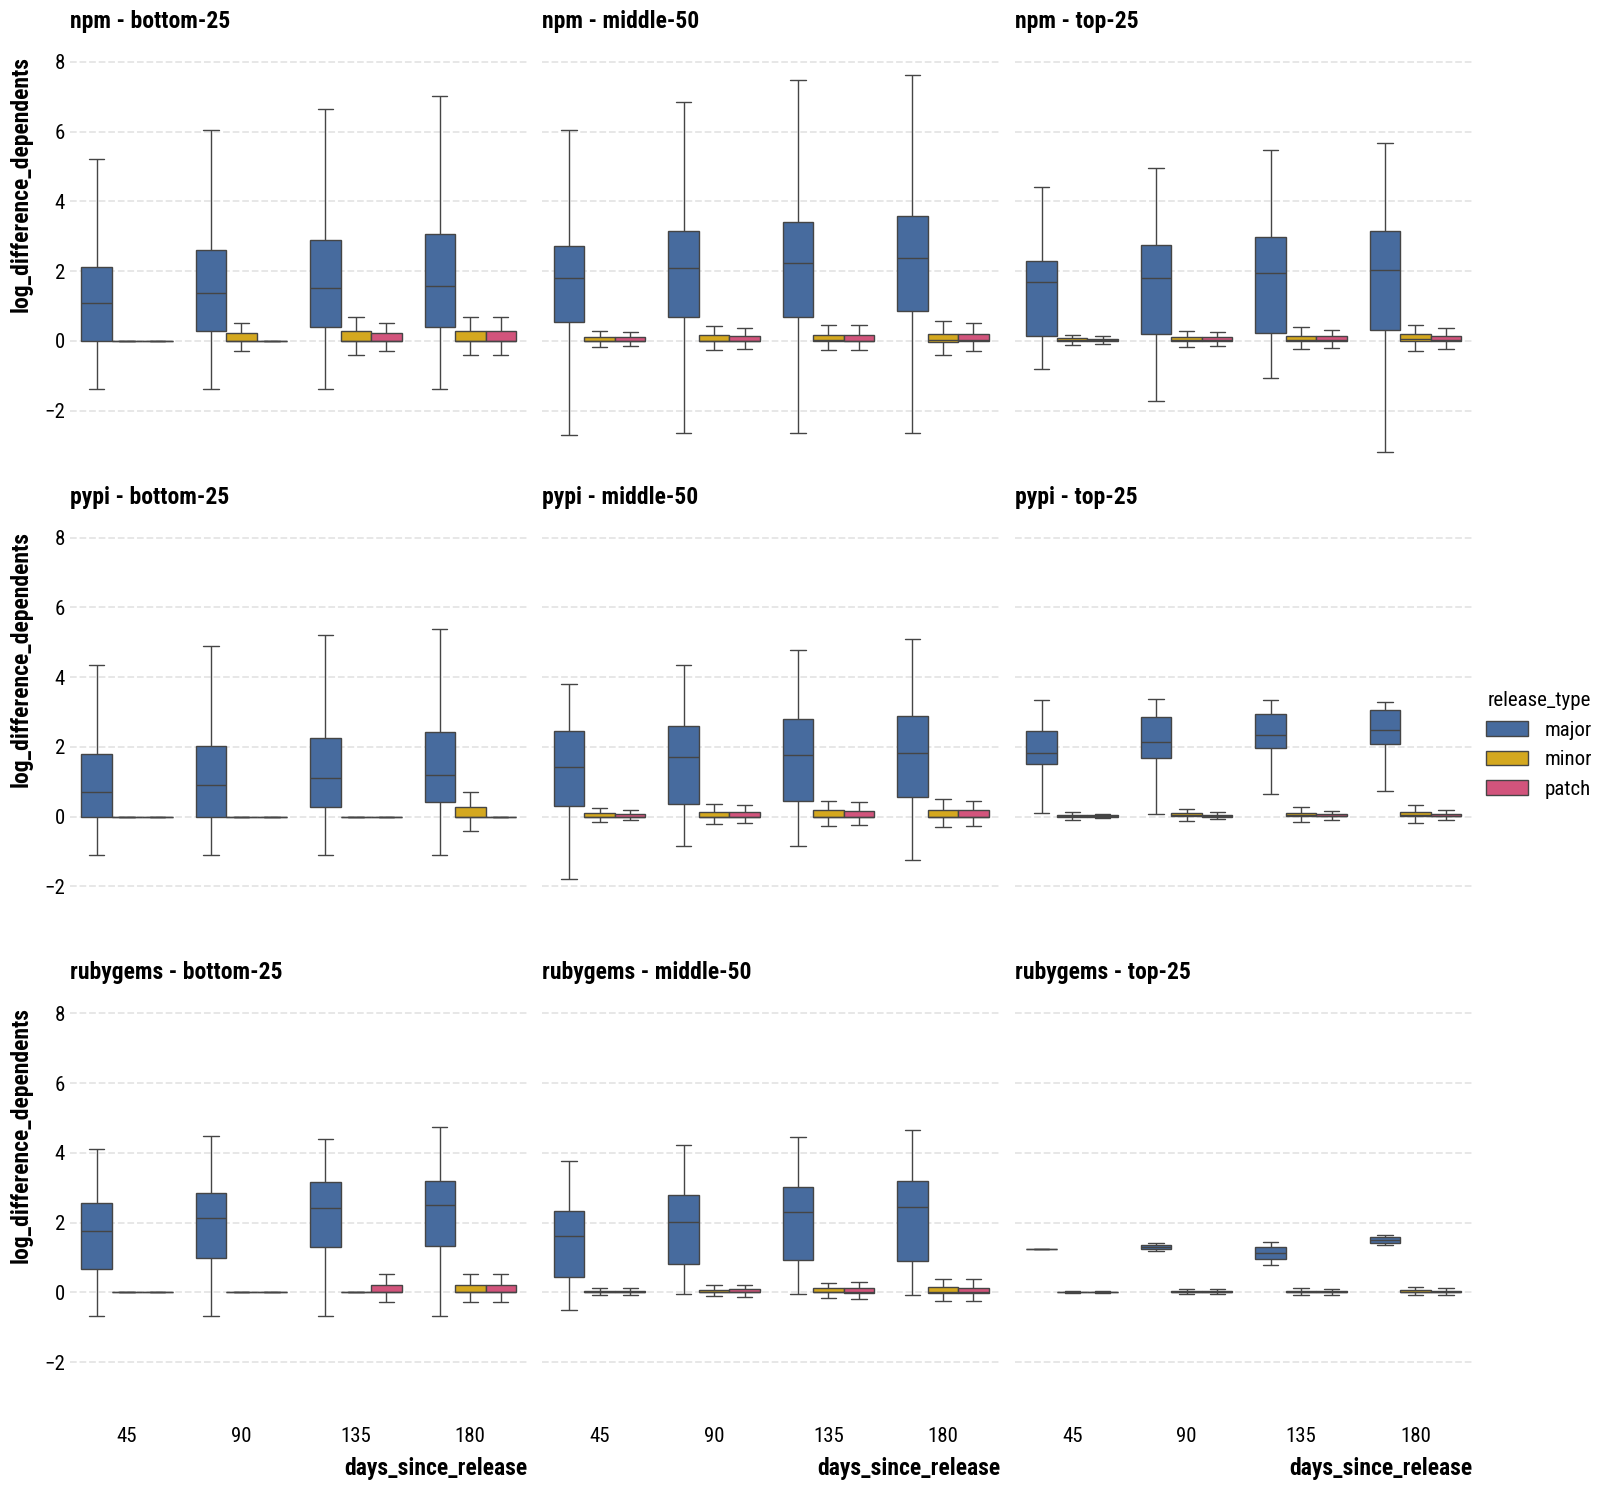

In [20]:
# Plot log difference dependents
g = sns.catplot(
    data=log_diff_dependents_ecosystem_release_type,
    x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="num_dependents_quantile",
    col_order=["bottom-25", "middle-50", "top-25"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

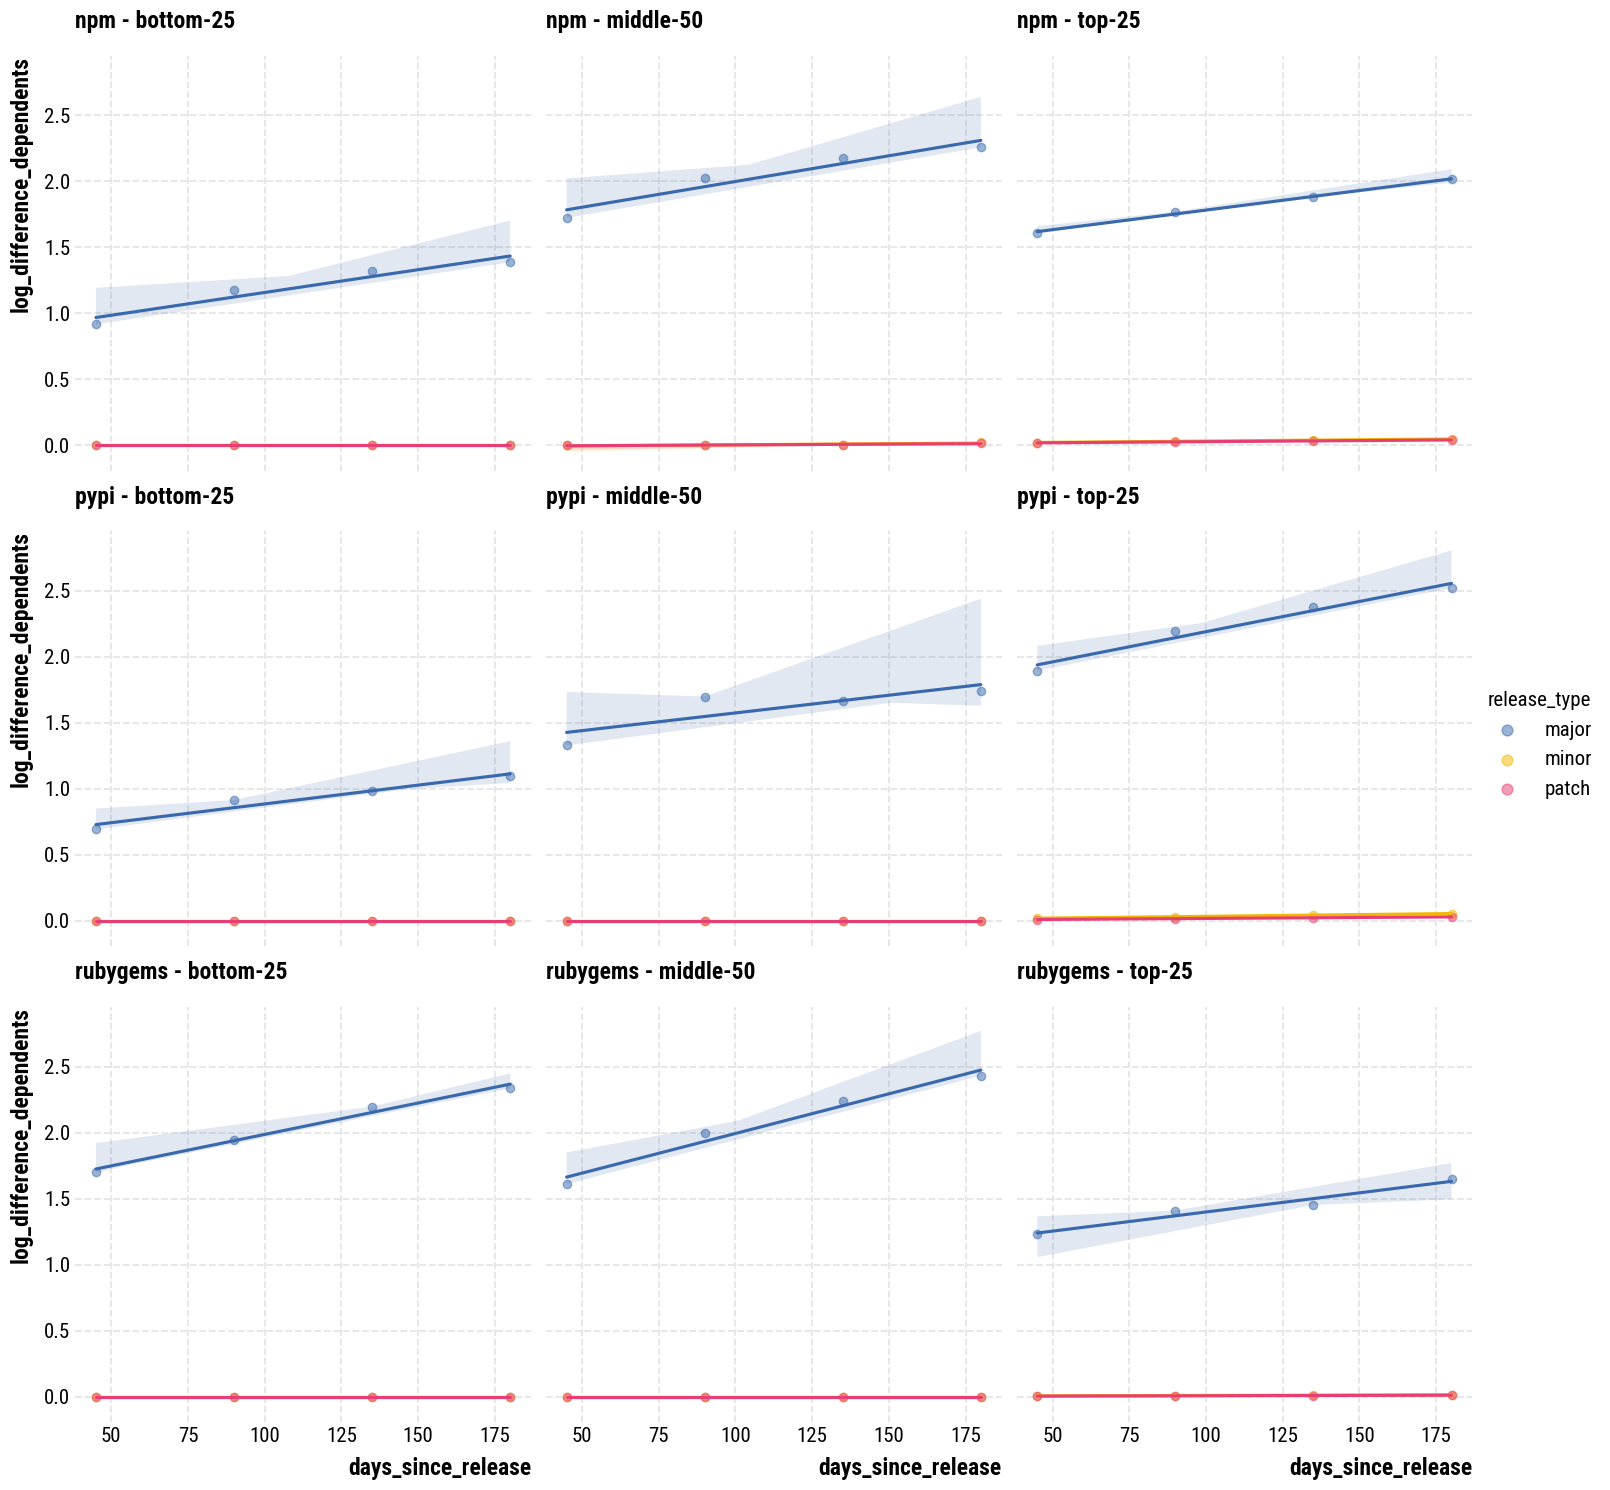

In [21]:
median_log_diff_dependents_initial_utilization = (
    log_diff_dependents_ecosystem_release_type.select(
        pl.col("ecosystem"),
        pl.col("release_type"),
        pl.col("num_dependents_quantile"),
        pl.col("days_since_release"),
        pl.col("log_difference_dependents"),
    )
    .group_by(
        pl.all().exclude("log_difference_dependents"),
    )
    .quantile(0.5)
)

# Plot log difference dependents
g = sns.lmplot(
    data=median_log_diff_dependents_initial_utilization,
    x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="num_dependents_quantile",
    col_order=["bottom-25", "middle-50", "top-25"],
    scatter_kws={"alpha": 0.5},
)

g.set_titles("{row_name} - {col_name}")

#### Log Difference in Dependents by Package Ecosystem and Release Series

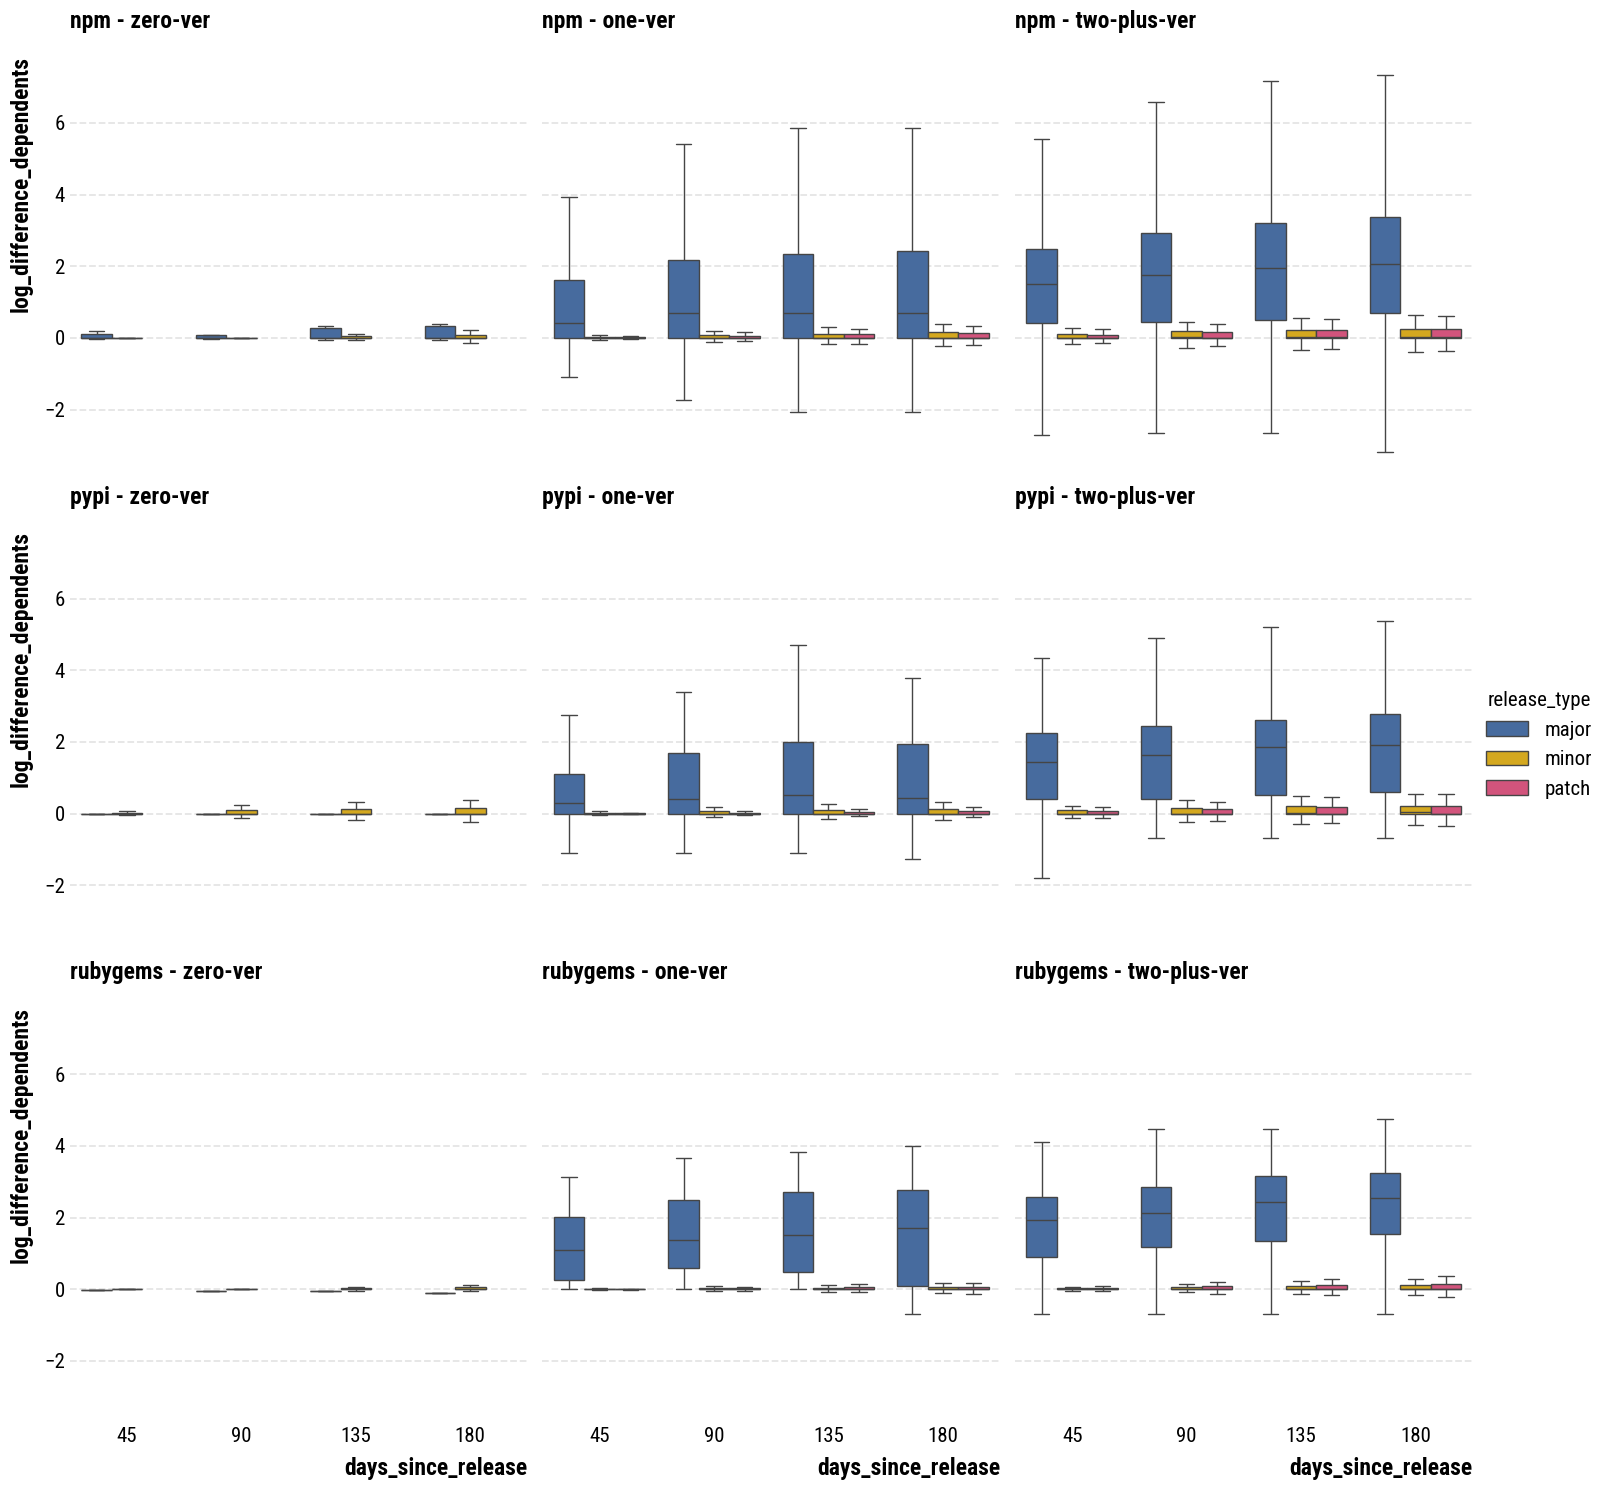

In [22]:
# Replace zero-ver release types
log_diff_dependents_ecosystem_release_type_replaced_zero_ver = (
    log_diff_dependents_ecosystem_release_type.select(
        pl.all().exclude("release_type"),
        pl.col("release_type")
        .str.replace("zero-major", "major")
        .str.replace("zero-minor", "minor")
        .alias("release_type"),
    )
)

# Plot log difference dependents
g = sns.catplot(
    data=log_diff_dependents_ecosystem_release_type_replaced_zero_ver,
    x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    kind="box",
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="version_series",
    col_order=["zero-ver", "one-ver", "two-plus-ver"],
    showfliers=False,
)

g.set_titles("{row_name} - {col_name}")

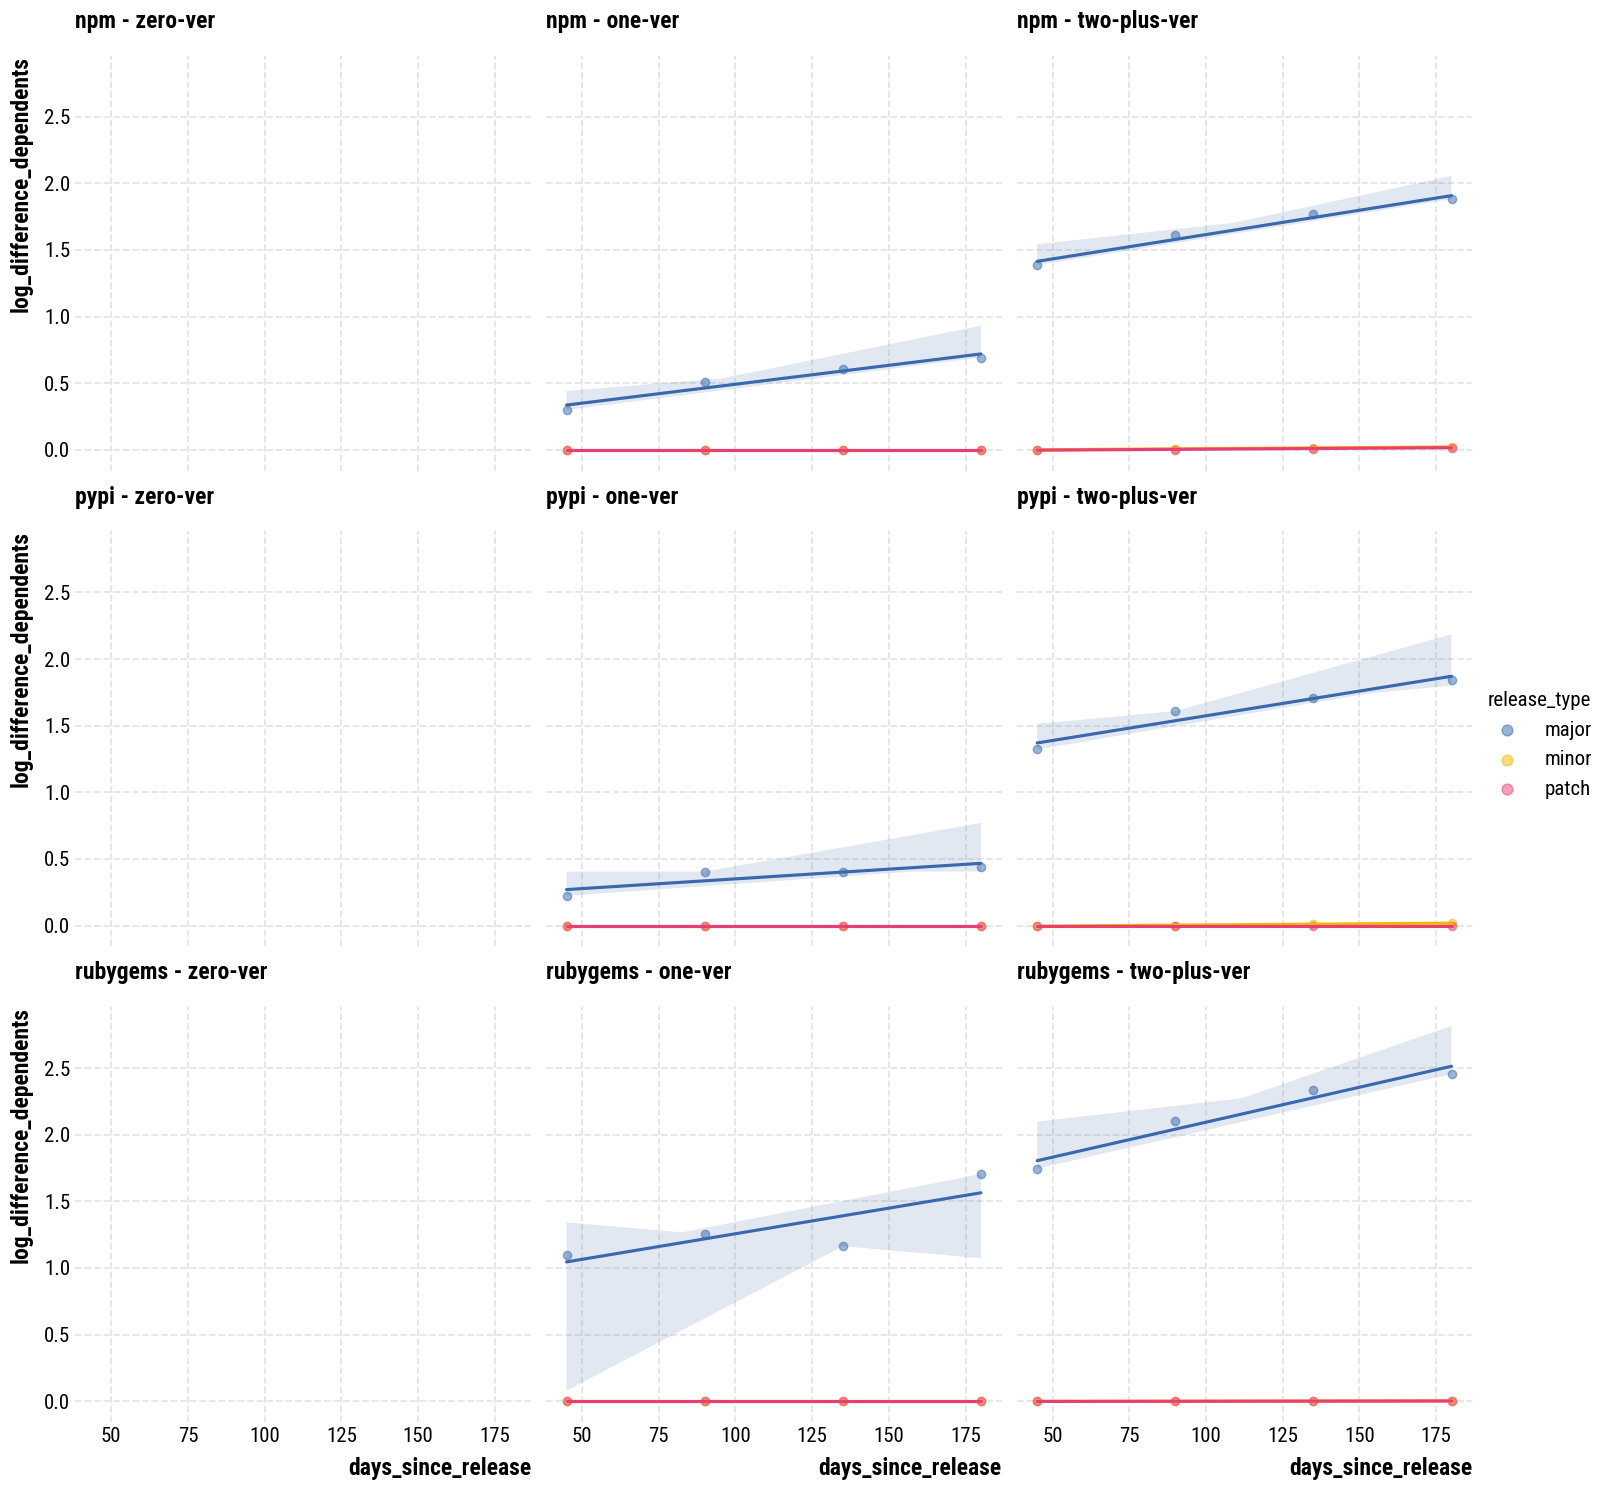

In [23]:
median_log_diff_dependents_release_series = (
    log_diff_dependents_ecosystem_release_type.select(
        pl.col("ecosystem"),
        pl.col("release_type"),
        pl.col("version_series"),
        pl.col("days_since_release"),
        pl.col("log_difference_dependents"),
    )
    .group_by(
        pl.all().exclude("log_difference_dependents"),
    )
    .quantile(0.5)
)

# Plot log difference dependents
g = sns.lmplot(
    data=median_log_diff_dependents_release_series,
    x="days_since_release",
    y="log_difference_dependents",
    hue="release_type",
    hue_order=["major", "minor", "patch"],
    row="ecosystem",
    row_order=["npm", "pypi", "rubygems"],
    col="version_series",
    col_order=["zero-ver", "one-ver", "two-plus-ver"],
    scatter_kws={"alpha": 0.5},
)

g.set_titles("{row_name} - {col_name}")